In [1]:
!pip install surprise

In [2]:
import json
import time
import numpy as np
import pandas as pd
from surprise import AlgoBase
from surprise import NormalPredictor
from surprise import PredictionImpossible
from surprise import KNNBasic
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

In [3]:
start = time.time()
with open('MA_users.json', encoding="utf8") as fin:
    print('Reading',fin.name)
    user_data = json.load(fin)
end = time.time()
duration_without_dr = end-start
print("Time taken to load user data: %d seconds" %duration_without_dr)


Reading MA_users.json
Time taken to load user data: 4 seconds


In [4]:
start = time.time()
with open('MA_restaurants.json', encoding="utf8") as fin:
    print('Reading',fin.name)
    restaurant_data = json.load(fin)
end = time.time()
duration_without_dr = end-start
print("Time taken to load restaurant data: %d seconds" %duration_without_dr)

Reading MA_restaurants.json
Time taken to load restaurant data: 0 seconds


In [5]:
start = time.time()
with open('MA_reviews.json', encoding="utf8") as fin:
    print('Reading',fin.name)
    review_data = json.load(fin)
end = time.time()
duration_without_dr = end-start
print("Time taken to load review data: %d seconds" %duration_without_dr)

Reading MA_reviews.json
Time taken to load review data: 14 seconds


In [6]:
print(str(len(user_data)) + ' user records loaded')
print(str(len(review_data)) + ' review records loaded')
print(str(len(restaurant_data)) + ' business records loaded')

125521 user records loaded
914710 review records loaded
10550 business records loaded


In [7]:
print(user_data[0].keys(),'\n')
print(review_data[0].keys(),'\n')
print(restaurant_data[0].keys(),'\n')

dict_keys(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny', 'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos']) 

dict_keys(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']) 

dict_keys(['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']) 



Create a 2d arary of user IDs and buisness IDs, with ratings(stars) as frequencies

In [8]:
user_id_dict = dict()
for i,u in enumerate(user_data):
    user_id_dict[u['user_id']] = i

business_id_dict = dict()
for i,r in enumerate(restaurant_data):
    business_id_dict[r['business_id']] = i

rating_mat = np.zeros((len(user_data), len(restaurant_data)))
rating_dict = {'user_id': [],
               'business_id': [],
               'rating': []}

for review in review_data:
    user_idx = user_id_dict[review['user_id']]
    business_idx = business_id_dict[review['business_id']]
    rating_mat[user_idx][business_idx] = review['stars']
    
    rating_dict['user_id'].append(review['user_id'])
    rating_dict['business_id'].append(review['business_id'])
    rating_dict['rating'].append(review['stars'])

print(rating_mat.shape)
print('number of non-zero elements(good ratings): ' +str(np.count_nonzero(rating_mat)))

(125521, 10550)
number of non-zero elements(good ratings): 879189


In [9]:
df = pd.DataFrame(rating_dict)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'business_id', 'rating']], reader)

In [10]:
from surprise.model_selection.split import train_test_split
trainset, testset = train_test_split(data, test_size=0.25)

sim_options = {'name': 'cosine',
               'user_based': False
               }
algo = KNNBasic(sim_options=sim_options)
predictions = algo.fit(trainset).test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [12]:
result = pd.DataFrame(predictions, columns=['user_id', 'business_id', 'base_event', 'predict_event', 'details'])
result.drop(columns = {'details'}, inplace = True)
result['erro'] = abs(result['base_event'] - result['predict_event'])
result.head()

,user_id,business_id,base_event,predict_event,erro
0,PUO9XBnodFX0bOTABnq0BA,tNhvsTqW-djjTPFTKBZInQ,1.0,4.256722,3.256722
1,jvQ4ZBCdN8LHEuZEwJBXug,xsdJ_ZYzpI-5pMcZ49M0og,1.0,3.717200,2.717200
2,dLxAxYJptBr3JxRVuJwGmg,MApTrkJdMvtJB59DqzLUGQ,2.0,4.262186,2.262186
3,NJ6cJj_8I3rrxbbMbMc8Bw,vxkOVmhReRa4XYfAT1hMxA,2.0,3.000000,1.000000
4,7HzEifIIJN60vlIRVp1XSA,ufp_6t4srHkYFcRft9nh6A,5.0,3.271903,1.728097


<AxesSubplot:>

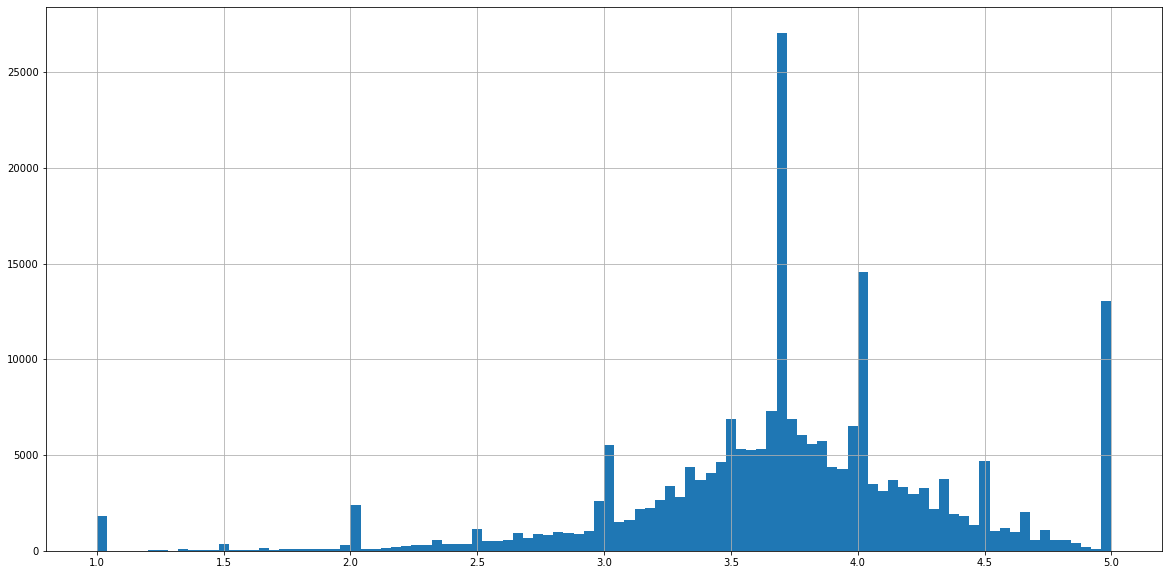

In [13]:
result['predict_event'].hist(bins= 100, figsize= (20,10))